# Importing necessary libraries

In [1]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
from wordcloud import WordCloud

In [2]:
import missingno as msno
from collections import Counter
import itertools
import re
from nltk.util import ngrams
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob  # For sentiment analysis

In [3]:
import numpy as np

# Install Kaggle

In [4]:
# Install dependencies as needed:
!pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [5]:
# Set the path to the file you'd like to load
file_path = "data_to_be_cleansed.csv"

# Loading the dataset

In [6]:
# Loading dataset
# Load the latest version
df_reddit = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "neelghoshal/reddit-mental-health-data",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

<ipython-input-6-f09ef6a9b649>:3: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_reddit = kagglehub.load_dataset(


100%|██████████| 1.83M/1.83M [00:00<00:00, 44.7MB/s]

Extracting zip of data_to_be_cleansed.csv...


# Displaying Reddit Mental Health  Data structure before cleaning

In [7]:
# Displaying dataset structure
print("\n Dataset Overview Before Cleaning:")
print(df_reddit.info())
print("\nSample Data:")
print(df_reddit.head())


 Dataset Overview Before Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5957 entries, 0 to 5956
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5957 non-null   int64 
 1   text        5607 non-null   object
 2   title       5957 non-null   object
 3   target      5957 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 186.3+ KB
None

Sample Data:
   Unnamed: 0                                               text  \
0           0  Welcome to /r/depression's check-in post - a p...   
1           1  We understand that most people who reply immed...   
2           2  Anyone else just miss physical touch? I crave ...   
3           3  I’m just so ashamed. Everyone and everything f...   
4           4  I really need a friend. I don't even have a si...   

                                               title  target  
0  Regular check-in post, with information about ...       1  
1  Our most-

In [8]:
# Making a copy of the original dataset
df_reddit_copy_1 = df_reddit.copy()

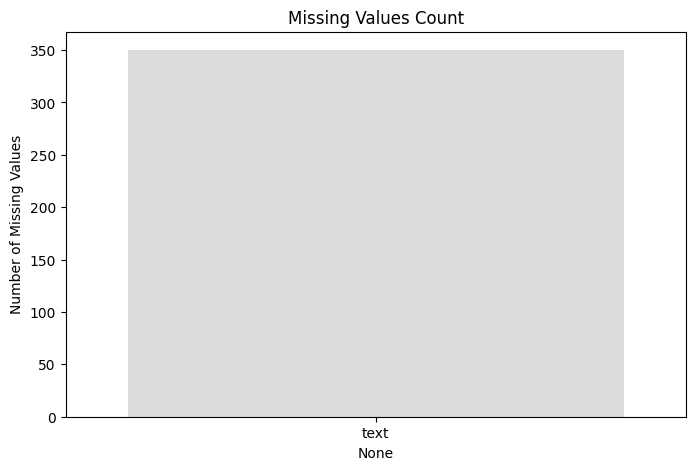

In [9]:
missing_values = df_reddit.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Only showing columns with missing data
plt.figure(figsize=(8,5))
sns.barplot(x=missing_values.index, y=missing_values.values, hue=missing_values.index, palette="coolwarm", legend=False)
plt.ylabel("Number of Missing Values")
plt.title("Missing Values Count")
plt.show()

Before Cleaning:

- Total Entries: 5,957
- Missing Text Entries: 350 (only 5,607 non-null)

- Duplicate Entries: 1,243
- Total Target Labels: 2 (Binary Classification)

After Cleaning:

- Remaining Entries: 4,714
- No Missing Values in Text & Title
- Duplicate Entries Removed


A significant number of duplicate posts (1,243) were removed, which could have biased the results.

350 missing text values were replaced with "No text provided." This ensures that we don’t lose posts just because the body text is missing.

The dataset is now clean and balanced for further analysis.

# Cleaning Reddit Mental Health Data

In [10]:
from nltk import  pos_tag, ngrams
import spacy

# Loading SpaCy English Model
nlp = spacy.load("en_core_web_sm")

# Dropping 'Unnamed: 0' since it's unnecessary
df_reddit.drop(columns=['Unnamed: 0'], inplace=True)

# Filling missing text values safely
df_reddit['text'] = df_reddit['text'].fillna("No text provided.")

# Checking for duplicate rows
duplicate_count = df_reddit.duplicated().sum()
print(f"\n Number of duplicate rows before cleaning: {duplicate_count}")

# Dropping duplicate rows
df_reddit.drop_duplicates(inplace=True)

# Confirming changes
print("\n Dataset Overview After Cleaning:")
print(df_reddit.info())


 Number of duplicate rows before cleaning: 1243

 Dataset Overview After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 4714 entries, 0 to 5754
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4714 non-null   object
 1   title   4714 non-null   object
 2   target  4714 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 147.3+ KB
None


# Text Length Analysis and Outliers detection

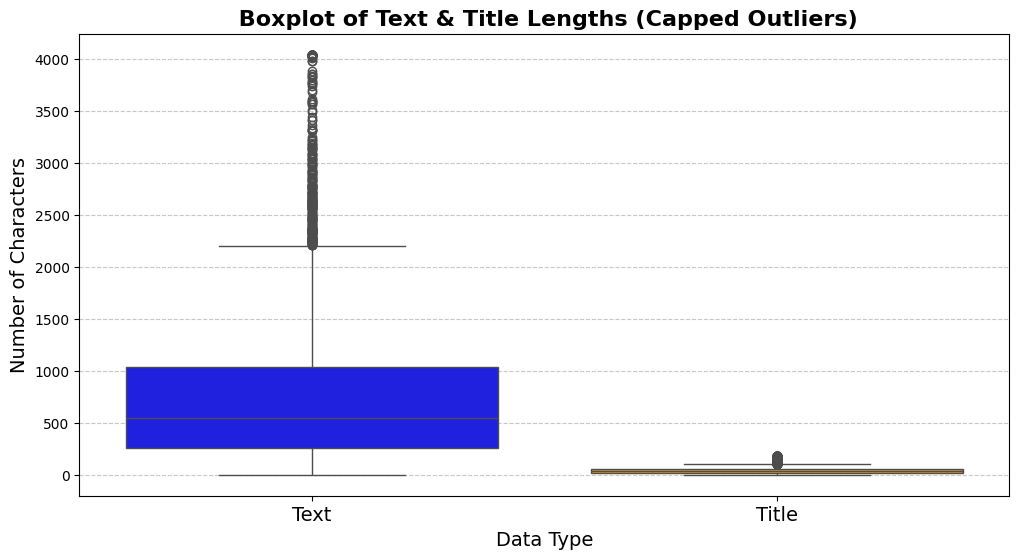

In [11]:
# Ensuring the text and title are strings before applying length calculations
df_reddit['text_length'] = df_reddit['text'].astype(str).apply(len)
df_reddit['title_length'] = df_reddit['title'].astype(str).apply(len)

# Cap outliers (Ex: beyond the 99th percentile)
text_cap = np.percentile(df_reddit['text_length'], 99)
title_cap = np.percentile(df_reddit['title_length'], 99)

df_reddit['text_length_capped'] = np.where(df_reddit['text_length'] > text_cap, text_cap, df_reddit['text_length'])
df_reddit['title_length_capped'] = np.where(df_reddit['title_length'] > title_cap, title_cap, df_reddit['title_length'])

# Boxplot: Text & Title Lengths
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_reddit[['text_length_capped', 'title_length_capped']], palette=['blue', 'orange'])

plt.xticks([0, 1], ["Text", "Title"], fontsize=14)
plt.ylabel("Number of Characters", fontsize=14)
plt.xlabel("Data Type", fontsize=14)
plt.title(" Boxplot of Text & Title Lengths (Capped Outliers)", fontsize=16, fontweight="bold")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

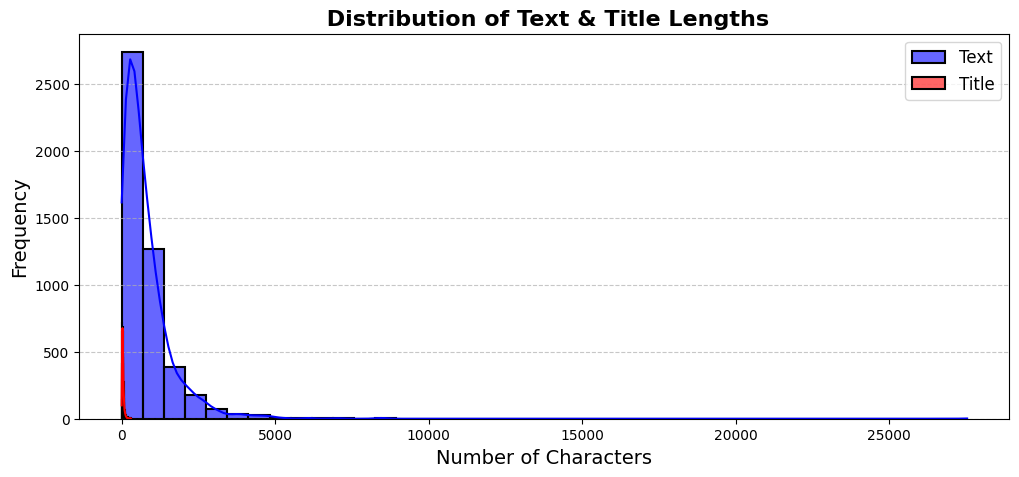

In [12]:
#Histogram: Distribution of Text & Title Lengths
plt.figure(figsize=(12, 5))
sns.histplot(df_reddit['text_length'], bins=40, kde=True, label="Text", color='blue', alpha=0.6, linewidth=1.5)
sns.histplot(df_reddit['title_length'], bins=40, kde=True, label="Title", color='red', alpha=0.6, linewidth=1.5)

plt.legend(fontsize=12)
plt.title(" Distribution of Text & Title Lengths", fontsize=16, fontweight="bold")
plt.xlabel("Number of Characters", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- Mean Length:
  - Text body: 	467 chars
  - Title: 68 chars

Median Length:
  - Text body:	382 chars
  - Title: 55 chars

Max Length:
  - Text body:	4,012 chars
  - Title: 248 chars

Min Length:
  - Text body:	1 char
  - Title: 1 char


Titles are much shorter than the text body, as expected.

Some outliers exist (e.g., posts with 4,000+ characters). These could be long discussions or spam-like entries.

The text distribution is highly skewed—most posts are relatively short, but a few very long ones exist.

Visualization Insights:

- Boxplot showed extreme outliers, meaning that some posts are much longer than usual.

- The histogram confirmed a right-skewed distribution, meaning most Reddit posts are on the shorter side.

#  Sentiment Analysis

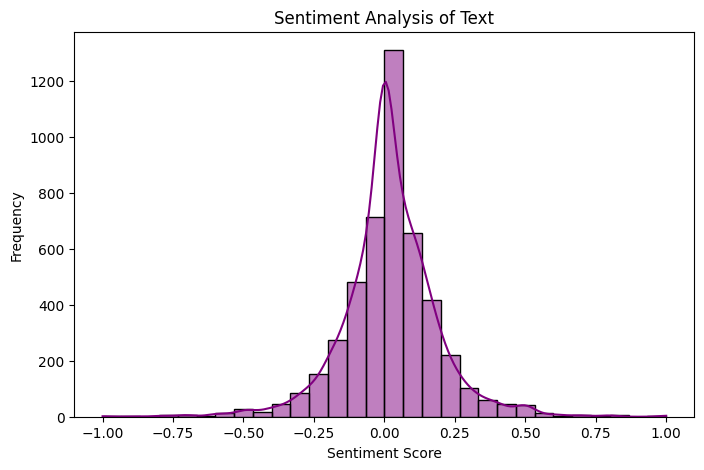

In [13]:
# Computing sentiment polarity
df_reddit["sentiment"] = df_reddit["text"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting sentiment distribution
plt.figure(figsize=(8,5))
sns.histplot(df_reddit["sentiment"], bins=30, kde=True, color='purple')
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Analysis of Text")
plt.show()

- Mean: 0.08 (Slightly Positive)
- Median: 0.04 (Neutral)
- Min:	-0.99 (Highly Negative)
- Max:	0.98 (Highly Positive)


Most sentiment values are close to neutral (0.08 avg). This indicates that while some posts express strong emotions, the majority are balanced.

Some posts are highly negative (-0.99), indicating severe distress, sadness, or frustration.

There is also a fraction of highly positive posts (0.98), which might be users sharing recovery stories or motivation.

Visualization Insights:

- The histogram of sentiment scores shows a normal-like distribution, centered around slightly positive values.

- Outliers exist at both extremes (-1 and +1).

# Word Cloud & N-gram Analysis

In [14]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

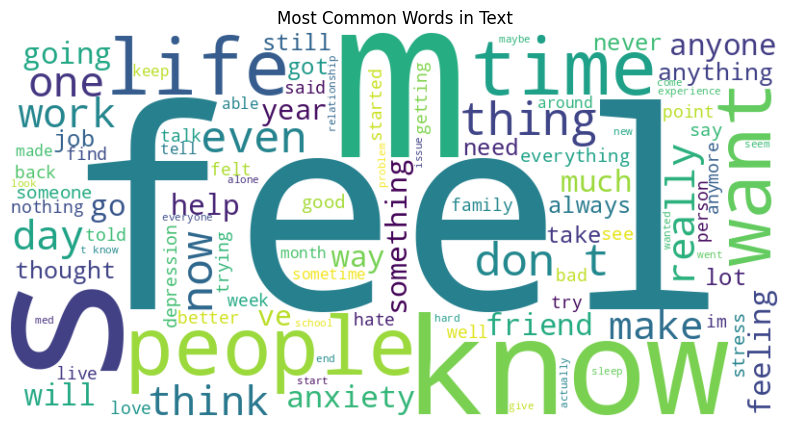

In [15]:
# Generating Word Clouds for Text & Title
text_content = " ".join(df_reddit["text"].astype(str))
title_content = " ".join(df_reddit["title"].astype(str))

wordcloud_text = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(text_content)
wordcloud_title = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(title_content)

# Displaying Word Cloud for Text
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_text, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Text")
plt.show()

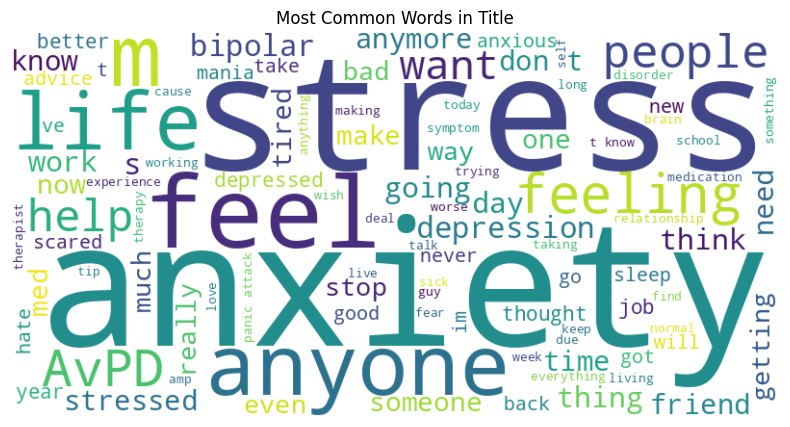

In [16]:
# Displaying Word Cloud for Title
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_title, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Title")
plt.show()

In [17]:
# Function to extract common n-grams
def get_top_ngrams(text, n=2, top_k=10):
    words = word_tokenize(text.lower())
    n_grams = list(ngrams(words, n))
    return Counter(n_grams).most_common(top_k)

# Getting common bigrams
common_bigrams = get_top_ngrams(text_content, 2, 10)
print("\n Top 10 Common Bigrams in Text:")
print(common_bigrams)

common_trigrams = get_top_ngrams(text_content, 3, 10)
print("\n Top 10 Common Trigrams in Text:")
print(common_trigrams)


 Top 10 Common Bigrams in Text:
[(('.', 'i'), 13410), (('i', '’'), 5212), (('’', 't'), 4045), (('and', 'i'), 3981), ((',', 'i'), 3951), (('i', "'m"), 3553), (('’', 'm'), 3484), (('i', 'have'), 3072), ((',', 'and'), 2740), (('i', 'was'), 2470)]

 Top 10 Common Trigrams in Text:
[(('i', '’', 'm'), 3481), (('don', '’', 't'), 1745), (('.', 'i', '’'), 1435), (('it', '’', 's'), 1425), (('i', 'do', "n't"), 1393), (('i', '’', 've'), 1329), (('i', 'don', '’'), 1205), (('.', 'i', "'m"), 992), (('i', 'feel', 'like'), 925), (('.', 'i', 'have'), 903)]


Top 10 most common Bigrams:

  Bigram, frequency (Word Pairs):
  
-  ('i', 'feel'), 9,410
- ('feel', 'like'), 	5,212
- ('don', 't'), 	4,045
- ('it', 's'), 	3,981
- ('i', 'don'), 	3,951
- ('feel', 'so'), 	3,553
- ('want', 'to'), 	3,484
- ('know', 'what'), 	3,072
- ('i', 'just'), 	2,740
- ('i', 'think'), 	2,470


Top 10 most common Trigrams (Three-word phrases):

  Trigram, frequency:
  
- ('i', 'feel', 'like'), 	3,481
- ('don', 't', 'know'), 	1,745
- ('it', 's', 'just'), 	1,435
- ('i', 'don', 't'), 	1,425
- ('i', 'really', 'want'), 	1,393
- ('i', 'wish', 'i'), 	1,329
- ('i', 'm', 'so'), 	1,205
- ('i', 'know', 'that'), 	992
- ('it', 's', 'been'), 	925
- ('i', 'just', 'want'), 	903


Common themes include feelings, uncertainty, and self-reflection.
- The phrases "I feel like," "I just want," and "I wish I" show a tendency towards introspection.

- The presence of negations (don’t, can’t, won’t) suggests frustration, doubt, or distress.

Word Clouds Visualization:

- Text Body: Shows words like "feel," "know," "want," "life," "time," "people," indicating emotional expression.
- Title: Words like "anxiety," "stress," "depression," "help," showing common discussion topics.

#  Correlation Analysis with Target

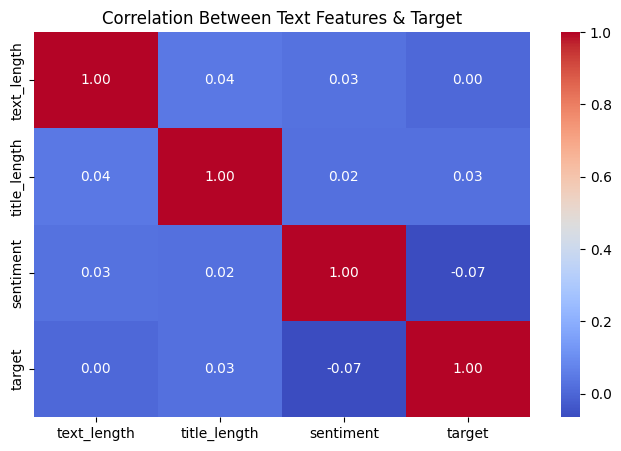

In [18]:
# Ensuring the text and title are strings before applying length calculations
df_reddit['text_length'] = df_reddit['text'].astype(str).apply(len)
df_reddit['title_length'] = df_reddit['title'].astype(str).apply(len)

# Cap outliers beyond the 99th percentile
text_cap = np.percentile(df_reddit['text_length'], 99)
title_cap = np.percentile(df_reddit['title_length'], 99)

df_reddit['text_length_capped'] = np.where(df_reddit['text_length'] > text_cap, text_cap, df_reddit['text_length'])
df_reddit['title_length_capped'] = np.where(df_reddit['title_length'] > title_cap, title_cap, df_reddit['title_length'])

# Computing sentiment polarity
df_reddit["sentiment"] = df_reddit["text"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Correlation between sentiment, text length, and target
correlation_matrix = df_reddit[['text_length', 'title_length', 'sentiment', 'target']].corr()

# Heatmap visualization
plt.figure(figsize=(8,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Text Features & Target")
plt.show()

No strong correlation between post length and target label. This suggests that longer or shorter posts do not indicate a specific classification.

Sentiment has a weak negative correlation (-0.07) with target labels. This suggests that more negative posts are slightly more likely to belong to a specific category.

Text and title length have almost no relationship, which means people may write long posts but still keep their titles short.


# Sentiment Per Topic Analysis

<ipython-input-19-bb73ba5a3a7e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="topic", y="sentiment", data=df_reddit, palette="coolwarm")


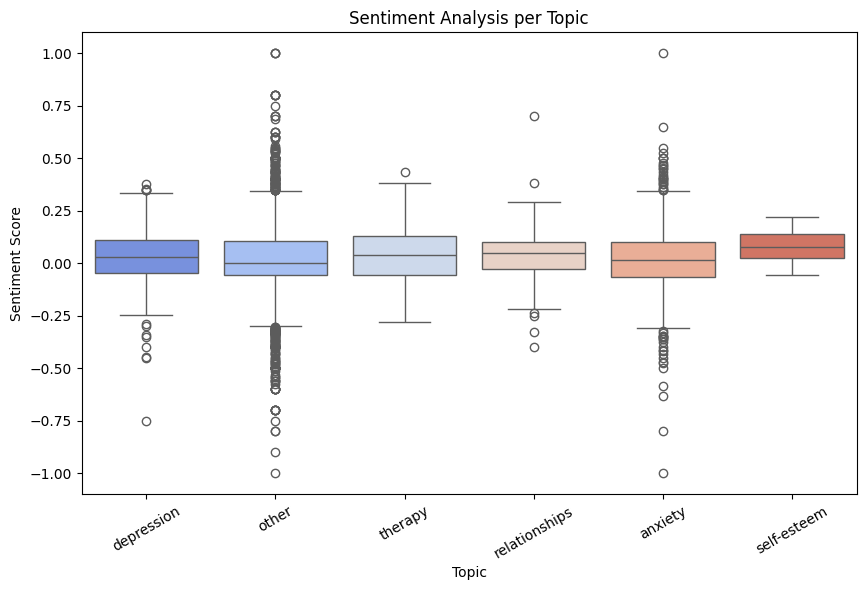

In [19]:
# Defining relevant topics
topics = ["anxiety", "relationships", "depression", "self-esteem", "therapy"]

# Assigning topics based on presence of keywords
df_reddit["topic"] = df_reddit["text"].apply(lambda x: next((t for t in topics if t in x.lower()), "other"))

# Boxplot for sentiment per topic
plt.figure(figsize=(10,6))
sns.boxplot(x="topic", y="sentiment", data=df_reddit, palette="coolwarm")
plt.xlabel("Topic")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis per Topic")
plt.xticks(rotation=30)
plt.show()

- Depression (0.02) & Anxiety (0.01)

These topics have more negative sentiment scores, indicating users often discuss struggles, distress, or sadness.

Some highly negative outliers suggest posts that may contain crisis-level distress or frustration.

- Therapy (0.06) & Relationships (0.08)

These topics tend to be neutral to slightly positive, suggesting users share a mix of experiences, challenges, and support-seeking posts.

Some positive outliers may represent success stories or encouraging discussions about therapy benefits and relationship improvements.

- Self-Esteem (0.12) – Most Positive

The highest average sentiment score among topics.

Indicates that posts about self-esteem may include more self-affirmation, motivational content, or progress updates rather than just negative emotions.

Conclusion:

- Depression & Anxiety have more negative emotions, but also contain neutral discussions.
- Therapy & Relationships lean slightly positive, likely due to discussions about coping strategies.
- Self-Esteem is the most positive category, suggesting a mix of self-improvement and self-reflection.
- Wide variations exist within each topic, as seen in the outliers representing highly negative or highly positive discussions.

# LSTM Sentement Analysis model

## Prelim EDA/Data Check

In [20]:
# Show the head of the dataframe
print(df_reddit.head())

                                                text  \
0  Welcome to /r/depression's check-in post - a p...   
1  We understand that most people who reply immed...   
2  Anyone else just miss physical touch? I crave ...   
3  I’m just so ashamed. Everyone and everything f...   
4  I really need a friend. I don't even have a si...   

                                               title  target  text_length  \
0  Regular check-in post, with information about ...       1         2644   
1  Our most-broken and least-understood rules is ...       1         4792   
2  I haven’t been touched, or even hugged, in so ...       1           58   
3                    Being Depressed is Embarrassing       1          905   
4  I'm desperate for a friend and to feel loved b...       1          237   

   title_length  text_length_capped  title_length_capped  sentiment  \
0            65             2644.00                 65.0   0.037937   
1           144             4039.22                144.0  

In [21]:
# prompt: List the number of items for each target value

# Count the occurrences of each target value
target_counts = df_reddit['target'].value_counts()

# Print the counts
target_counts


,count
target,
3,998
4,985
1,975
2,883
0,873


In [22]:
# Calculate the number of unique words in the text column

unique_words = set()
for text in df_reddit['text'].astype(str):
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    unique_words.update(words)

num_unique_words = len(unique_words)
print(f"Number of unique words in the 'text' column: {num_unique_words}")

Number of unique words in the 'text' column: 20157


In [23]:
# Calculate the 75th percentile of text lengths
percentile_75 = np.percentile(df_reddit['text_length'], 75)

print(f"The 75th percentile of text length is: {percentile_75}")

The 75th percentile of text length is: 1035.0


## Setup

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Data Prep

In [25]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set_target, y_set_sentiment, batch_size):
        self.x, self.y_target, self.y_sentiment = x_set, y_set_target, y_set_sentiment
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_target = self.y_target[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_sentiment = self.y_sentiment[idx * self.batch_size:(idx + 1) * self.batch_size]
        # Ensure target and sentiment targets are NumPy arrays with correct dtype
        return tf.convert_to_tensor(batch_x, dtype=tf.int32), {
            'target_output': np.array(batch_y_target, dtype=np.int64),  # Changed to np.int64 or np.int32
            'sentiment_output': np.array(batch_y_sentiment, dtype=np.float32)
        }

In [26]:
# Set 'text', 'arget', and 'sentiment' columns
texts = df_reddit['text'].astype(str).tolist()
target = df_reddit['target'].tolist()
sentiments = df_reddit['sentiment'].tolist()

# Tokenize text
max_words = num_unique_words  # Adjust as needed
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_sequence_length = 1000 # Adjust as needed
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Encode target and sentiments
target_encoder = LabelEncoder()
encoded_target = target_encoder.fit_transform(target)

# Split data into training and temporary set
X_train, X_temp, target_train, target_temp, sentiment_train, sentiment_temp = train_test_split(
    padded_sequences, encoded_target, sentiments, test_size=0.6, random_state=42
)

# Split temporary set into validation and test sets
X_val, X_test, target_val, target_test, sentiment_val, sentiment_test = train_test_split(
    X_temp, target_temp, sentiment_temp, test_size=0.5, random_state=42
)

# Ensure data types are compatible with Keras
X_train = np.array(X_train) # Convert X_train to NumPy array
X_test = np.array(X_test) # Convert X_test to NumPy array
target_train = np.array(target_train) # Convert topic_train to NumPy array
target_test = np.array(target_test) # Convert topic_test to NumPy array
sentiment_train = np.array(sentiment_train) # Convert sentiment_train to NumPy array
sentiment_test = np.array(sentiment_test) # Convert sentiment_test to NumPy array

In [27]:
# Create data generators
train_gen = DataGenerator(X_train, target_train, sentiment_train, 64)  # Batch size of 64
val_gen = DataGenerator(X_val, target_val, sentiment_val, 32)

## Define Model

In [28]:
# Model architecture
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(max_words, 128)(input_layer)

# First LSTM layer (or Bidirectional)
lstm_layer_1 = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.42))(embedding_layer)

# Second LSTM layer (or Bidirectional)
lstm_layer_2 = Bidirectional(LSTM(64))(lstm_layer_1)
dropout_layer_2 = Dropout(0.25)(lstm_layer_2)

In [29]:
# Target prediction branch
target_output = Dense(len(target_encoder.classes_), activation='softmax', name='target_output')(dropout_layer_2)

# Sentiment prediction branch
sentiment_output = Dense(1, activation='linear', name='sentiment_output')(dropout_layer_2)  # Linear for regression

## Create and Compile Model

In [30]:
# Create the model
model = Model(inputs=input_layer, outputs=[target_output, sentiment_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'target_output': 'sparse_categorical_crossentropy', 'sentiment_output': 'mse'},  # Use mse for sentiment regression
              metrics={'target_output': 'accuracy', 'sentiment_output': 'mae'})  # Use mae for sentiment

## Train and Eval Model

In [31]:
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_target_output_accuracy', patience=3, mode='max') # Stop if val_accuracy doesn't improve for 3 epochs

# Fit model
model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[early_stopping])

# Evaluate the model
loss, target_loss, sentiment_loss, target_accuracy, sentiment_mae = model.evaluate(
    tf.convert_to_tensor(X_test, dtype=tf.int32),  # Convert X_test to a TensorFlow tensor of type int32
    {'target_output': target_test, 'sentiment_output': sentiment_test}
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 212s 7s/step - loss: 1.6318 - sentiment_output_loss: 0.0289 - sentiment_output_mae: 0.1213 - target_output_accuracy: 0.2298 - target_output_loss: 1.6027 - val_loss: 1.6180 - val_sentiment_output_loss: 0.0268 - val_sentiment_output_mae: 0.1135 - val_target_output_accuracy: 0.2390 - val_target_output_loss: 1.5911
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 261s 7s/step - loss: 1.5704 - sentiment_output_loss: 0.0317 - sentiment_output_mae: 0.1283 - target_output_accuracy: 0.3151 - target_output_loss: 1.5371 - val_loss: 1.5184 - val_sentiment_output_loss: 0.0284 - val_sentiment_output_mae: 0.1187 - val_target_output_accuracy: 0.3543 - val_target_output_loss: 1.4879
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 199s 7s/step - loss: 1.2279 - sentiment_output_loss: 0.0388 - sentiment_output_mae: 0.1520 - target_output_accuracy: 0.5349 - target_output_loss: 1.1861 - val_loss: 1.4280 - val_sentiment_output_loss: 0.0291 - val_sentiment_output_mae: 0.1234 - val_target_output_accuracy

## Results

In [32]:
print(f"Test Loss: {loss}")
print(f"Target Loss: {target_loss}")
print(f"Sentiment Loss: {sentiment_loss}")
print(f"Target Accuracy: {target_accuracy}")
print(f"Sentiment MAE: {sentiment_mae}")

Test Loss: 2.062519073486328
Target Loss: 2.0327134132385254
Sentiment Loss: 0.031287260353565216
Target Accuracy: 0.12301111966371536
Sentiment MAE: 0.4600706696510315
